In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
    return 5*x**2 - 3*x

In [3]:
f(5.0)

110.0

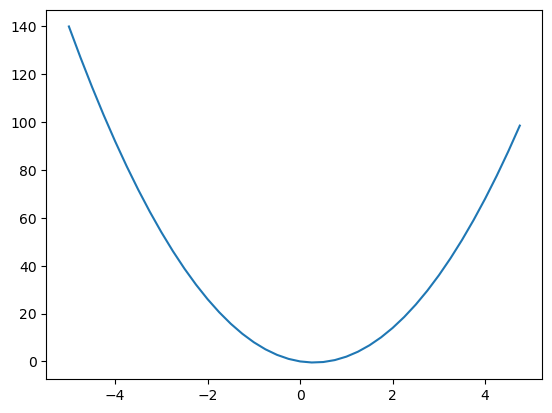

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0001
x = 3.0
(f(x + h) - f(x)) / h

27.00050000001397

In [6]:
# let's get more complex
a = 2.0
b = 3.0
c = -2.0
d = a*b+c
d

4.0

In [7]:
h = 0.0001

# let's get more complex
a = 2.0
b = 3.0
c = -2.0

d1 = a*b+c
a += h
d2 = a*b+c

print(f'd1: {d1}')
print(f'd2: {d2}')
print(f'slope: {(d2 - d1)/h}')

d1: 4.0
d2: 4.000300000000001
slope: 3.000000000010772


In [8]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """_summary_

        Args:
            data (Float): Scalar variable representing the value of this object.
            grad (Float): Will keep track of the gradient/derivative of this Value w.r.t. output node
            _children (tuple, optional): Tuple of previous nodes, will be stored as a Set(). Defaults to ().
            _op (str, optional): Operation between the _children nodes that produced this node. Defaults to ''.
            label (str, optional): Label for this node in graph. Defaults to ''.
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, power): # self**power
        assert isinstance(power, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**power, (self,), f'**{power}')

        def _backward():
            self.grad += (power * self.data**(power-1)) * out.grad
        out._backward = _backward

        return out  
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self.data * other**-1
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
            
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [9]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [10]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [11]:
# tells us L was produced by an addition of self._prev numbers
L._op

'*'

In [12]:
L.label

'L'

In [13]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

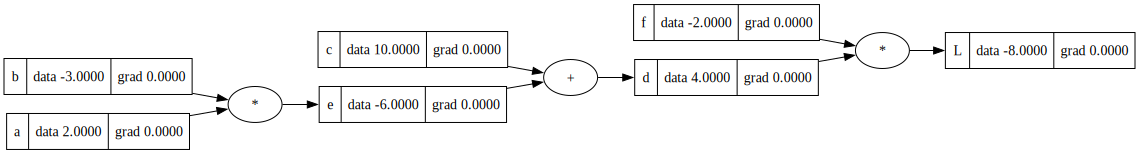

In [14]:
draw_dot(L)

L = d*f

dL/dd =? f

(f(x+h) - f(x)) / h

((d+h) * f - (d*f)) / h

((d*f + h*f) - d*f) / h

h*f / h

f

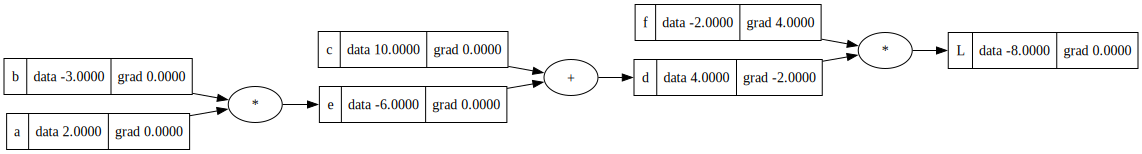

In [15]:
# Next we will perform backpropagation, for each node in the graph will calc the derivative of the output L w.r.t. the node
# usually do not want the derivative of loss function w.r.t. input b/c input is fixed
f.grad = 4.0
d.grad = -2.0
draw_dot(L)

dd / dc = 1.0
dd / de = 1.0

WANT:
dL / dc = ? -> (dL / dd) * (dd / dc)

KNOW:
dL /dd
dd / dc

Micrograd is a scalar based engine. It was modeled after pytorch. In pytorch, everything is done with tensors/matrices. Could change micrograd to work with tensors?

In [16]:
class Neuron:
    def __init__(self, n_inputs):
        self.w = [Value(random.uniform(-1,1)) for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1,1))
        
    def parameters(self):
        return self.w + [self.b]
        
    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    
class Layer:
    # TODO: Implement shape member function
    
    def __init__(self, n_inputs, n_outputs):
        '''
            Initialize neurons for layer. Each neuron should have weights for
            given inputs. Number of neurons in layer should equal n_outputs for layer.
            Each neuron provides a single output from the layer to the next.
        '''
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
    def __call__(self, x):
        # why is single input x going into each neuron?
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MultiLayerPerception:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [17]:
x = [2.0, 3.0, 4.0]
n = MultiLayerPerception(2, [4, 4, 1])
n(x)

Value(data=-0.3837746257116384)

In [18]:
len(n.parameters())

37

In [19]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # targets

In [26]:
for k in range(1000):
    ypred = [n(x) for x in xs]
    loss = sum([(yPred - yTarget)**2 for yTarget, yPred in zip(ys, ypred)])    
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update (gradient descent)
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(k, loss.data)

0 1.3133465504021162
1 1.2517615663060566
2 1.2180045622573565
3 1.2609917058916391
4 1.3449274320214295
5 1.429079295562028
6 1.524435966571714
7 1.6174400778079918
8 1.6962195503695179
9 1.7812984937497467
10 1.8521345233497615
11 1.9194883664689717
12 1.9921692011334482
13 1.5289345939008325
14 1.6232721882745111
15 1.3250072645231663
16 1.4181438830408468
17 1.432522034202787
18 1.5189597046391172
19 1.6146640386625184
20 1.4714916048128093
21 1.5537088421309646
22 1.452768572607293
23 1.2115859819679802
24 1.1538909795019614
25 1.1858651357735779
26 1.2844993224767984
27 1.3761961814860653
28 1.458259655756986
29 1.2121834286687594
30 1.1534109821880365
31 1.1941711459551976
32 1.2733416941736972
33 1.1636956884779561
34 1.166293290638555
35 1.1725311373595022
36 1.180825682343153
37 1.2475483535692995
38 1.3325017138548936
39 1.1815949993522803
40 1.1736239479592838
41 1.1437455990089744
42 1.1849297276963615
43 1.265381899469735
44 1.2766675999459909
45 1.2032570381096614
46 1.3

In [27]:
ypred

[Value(data=0.9917225968379584),
 Value(data=-0.8038122085201049),
 Value(data=-0.8196495297510411),
 Value(data=0.840780714840247)]